In [1]:
!pip install tensorflow pandas numpy


Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 6754.1626 - mae: 49.0165 - val_loss: 2379.5085 - val_mae: 27.9934
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1611.0885 - mae: 22.7241 - val_loss: 446.8490 - val_mae: 13.5607
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 350.2995 - mae: 12.2756 - val_loss: 146.4877 - val_mae: 8.7634
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118.9698 - mae: 7.6407 - val_loss: 53.9213 - val_mae: 4.7505
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.6241 - mae: 4.5663 - val_loss: 44.5244 - val_mae: 4.1292
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.3876 - mae: 4.2190 - val_loss: 42.5932 - val_mae: 4.2103
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.7670 - mae: 4.0536 - val_loss: 45.4156 - val_mae: 4.6598
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38.4024 - mae: 4.0356 - val_loss: 39.8222 - val_mae: 3.8945
Epoch 9/100
136/

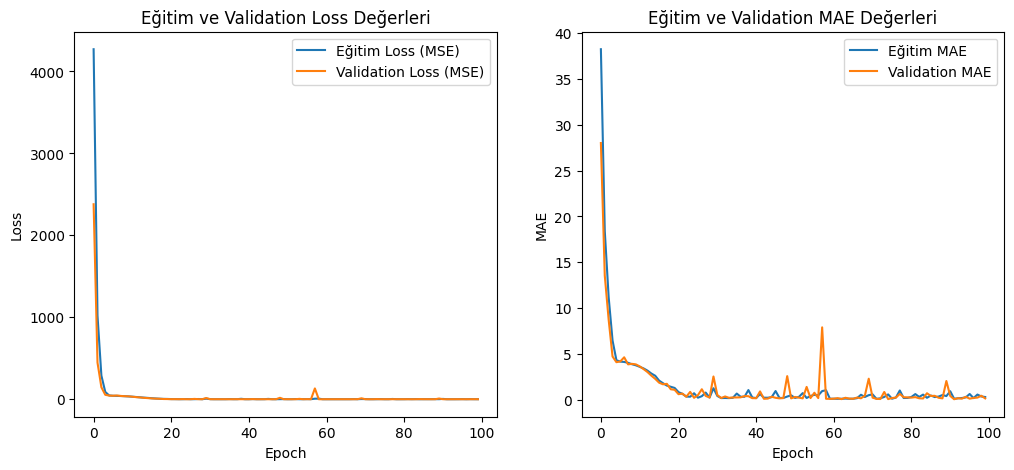

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0858 - mae: 0.1801
Test Loss (Besin Tahmini): 0.0894927978515625
Test MAE (Besin Tahmini): 0.18250517547130585
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Model Accuracy (R^2 Score): 0.9944607809427612


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 📌 Kullanıcı veri setini yükle
user_df = pd.read_csv("Final_Updated_User_Dataset.csv")
food_df = pd.read_csv("Food_Dataset.csv")

# 📌 Kullanıcı veri setindeki sütunları temizle
user_df.columns = user_df.columns.str.lower().str.replace(" ", "_")
food_df.columns = food_df.columns.str.lower().str.replace(" ", "_")

# 📌 Hipertansiyon ve diyabet sütunlarını 0/1 formatına çevir
user_df["bpq020"] = user_df["bpq020"].apply(lambda x: 1 if x == 1 else 0)
user_df["diq010"] = user_df["diq010"].apply(lambda x: 1 if x == 1 else 0)

# 📌 Hedef değişkenleri belirle
nutrition_targets = ["protein_(g)", "fat_(g)", "carbs_(g)", "sodium_(mg)"]

# 📌 Kullanıcı özellikleri ve hedef değerler
X = user_df[["riagendr", "ridageyr", "bpq020", "diq010"]].values  # Kullanıcı bilgileri
Y1 = user_df[nutrition_targets].values  # Günlük besin ihtiyacı

# 📌 Eğitim, validation ve test setlerine ayır (70% eğitim, 15% validation, 15% test)
X_train, X_temp, Y1_train, Y1_temp = train_test_split(X, Y1, test_size=0.3, random_state=42)
X_val, X_test, Y1_val, Y1_test = train_test_split(X_temp, Y1_temp, test_size=0.5, random_state=42)

# 📌 Modeli oluştur
input_layer = layers.Input(shape=(4,))
hidden = layers.Dense(128, activation="relu")(input_layer)
hidden = layers.Dense(64, activation="relu")(hidden)
hidden = layers.Dense(32, activation="relu")(hidden)

# 📌 Çıkış 1: Günlük besin ihtiyacı tahmini
nutrition_output = layers.Dense(4, activation="linear", name="nutrition_output")(hidden)

# 📌 Modeli birleştir
model = models.Model(inputs=input_layer, outputs=nutrition_output)

# 📌 Modeli derle
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),  # Öğrenme oranını biraz artırdık
    loss="mse",
    metrics=["mae"]
)

# 📌 Modeli eğit
history = model.fit(
    X_train, Y1_train,
    epochs=100,
    validation_data=(X_val, Y1_val),  # Validation set eklendi!
    verbose=1
)

print("Model Eğitildi! 🚀")

# 📌 Eğitim ve validation sürecini görselleştirme
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Eğitim ve Validation Loss Değerleri")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Eğitim MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.title("Eğitim ve Validation MAE Değerleri")
plt.show()

# 📌 Test seti üzerinde modeli değerlendir
test_results = model.evaluate(X_test, Y1_test)
print(f"Test Loss (Besin Tahmini): {test_results[0]}")
print(f"Test MAE (Besin Tahmini): {test_results[1]}")

# 📌 Modelin doğruluğunu (accuracy) ölçme
Y1_pred = model.predict(X_test)
accuracy = r2_score(Y1_test, Y1_pred)  # R^2 skorunu hesapla
print(f"Model Accuracy (R^2 Score): {accuracy}")




In [3]:
!pip uninstall openai -y

!pip install --upgrade openai

Found existing installation: openai 1.66.5
Uninstalling openai-1.66.5:
  Successfully uninstalled openai-1.66.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.1/606.1 kB 16.8 MB/s eta 0:00:00


In [4]:
!pip install --upgrade openai langchain



In [5]:
!pip install --upgrade langchain langchain-community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00


In [6]:
import openai
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
import numpy as np

In [7]:
!pip install tensorflow pandas numpy matplotlib scikit-learn --quiet
!pip install --upgrade openai langchain langchain-community --quiet

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from langchain_core.messages import SystemMessage, HumanMessage

import openai
from langchain.chat_models import ChatOpenAI


In [21]:
# Modeli test
new_user = np.array([[1, 37, 1, 1]])  # Yeni kullanıcı: Cinsiyet, Yaş, Hipertansiyon, Diyabet
predicted_nutrition = model.predict(new_user)[0]
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")

# OpenAI API anahtarını tanımla
openai.api_key = ""

# LangChain OpenAI modeli tanımla
llm = ChatOpenAI(model="gpt-4", openai_api_key=openai.api_key)

# 📌 Kullanıcıdan tercihler alınır (Boş bırakılabilir)
preferences = input("\n🍽️ Beslenme tercihlerinizi girin (örnek: vegan, Türk mutfağı, glütensiz) veya boş bırakın: ").strip()
allergies = input("⚠️ Alerjiniz varsa yazın (örnek: fındık, süt, yumurta) veya boş bırakın: ").strip()


# 📌 Prompt oluşturma fonksiyonu
def generate_prompt(predicted_nutrition, preferences="", allergies=""):
    # Günlük besin ihtiyaçlarını 3 öğüne böl
    breakfast_nutrition = predicted_nutrition / 3
    lunch_nutrition = predicted_nutrition / 3
    dinner_nutrition = predicted_nutrition / 3

    prompt = f"""
    Bir kullanıcı için günlük yemek önerileri yapmanı istiyorum. Kullanıcının günlük besin ihtiyaçları şu şekilde:

    - **Toplam Protein**: {predicted_nutrition[0]:.2f} g
    - **Toplam Yağ**: {predicted_nutrition[1]:.2f} g
    - **Toplam Karbonhidrat**: {predicted_nutrition[2]:.2f} g
    - **Toplam Sodyum**: {predicted_nutrition[3]:.2f} mg

    Bu besin değerlerini **kahvaltı, öğle yemeği ve akşam yemeği** olarak eşit şekilde bölmelisin.

    🥞 **Kahvaltı (3 yemek)**
    - **Protein**: {breakfast_nutrition[0]:.2f} g
    - **Yağ**: {breakfast_nutrition[1]:.2f} g
    - **Karbonhidrat**: {breakfast_nutrition[2]:.2f} g
    - **Sodyum**: {breakfast_nutrition[3]:.2f} mg

    🍛 **Öğle Yemeği (3 yemek)**
    - **Protein**: {lunch_nutrition[0]:.2f} g
    - **Yağ**: {lunch_nutrition[1]:.2f} g
    - **Karbonhidrat**: {lunch_nutrition[2]:.2f} g
    - **Sodyum**: {lunch_nutrition[3]:.2f} mg

    🍲 **Akşam Yemeği (3 yemek)**
    - **Protein**: {dinner_nutrition[0]:.2f} g
    - **Yağ**: {dinner_nutrition[1]:.2f} g
    - **Karbonhidrat**: {dinner_nutrition[2]:.2f} g
    - **Sodyum**: {dinner_nutrition[3]:.2f} mg
    """

    if preferences:
        prompt += f"\n- Kullanıcının **tercihleri**: {preferences}"

    if allergies:
        prompt += f"\n- Kullanıcının **alerjileri**: {allergies}"

    prompt += """

    **Önemli Kurallar:**
    - **Toplamda 9 farklı yemek önerisi** yap (kahvaltı, öğle, akşam için 3'er adet).
    - **Besin değerleri verilen hedeflere uygun olmalı ve toplam günlük besin ihtiyacı aşılmamalıdır.**
    - Yemeklerin **farklı besin gruplarından** olmasına dikkat et.
    """

    if allergies:
        prompt += "\n- **Alerjen içerikli hiçbir malzeme kullanılmamalı**. Kullanıcı alerjisi olan besinleri kesinlikle içermemeli."

    if preferences:
        prompt += "\n- **Tercihlere mutlaka uyulmalı**, aksi takdirde öneri geçersiz sayılır."

    prompt += """

    **Yanıt Formatı (Örnek):**

    🥞 **Kahvaltı:**
    1️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg
    2️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg
    3️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg

    🍛 **Öğle Yemeği:**
    1️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg
    2️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg
    3️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg

    🍲 **Akşam Yemeği:**
    1️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg
    2️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg
    3️⃣ [Yemek Adı] - Protein: X g, Yağ: Y g, Karbonhidrat: Z g, Sodyum: W mg

    **Önemli:** Lütfen yukarıdaki formatı kullanarak yanıt ver.
    """

    return prompt

# 📌 GPT ile yemek önerisi fonksiyonu
def recommend_meals_with_langchain(predicted_nutrition, preferences="", allergies=""):
    prompt = generate_prompt(predicted_nutrition, preferences, allergies)

    messages = [
        SystemMessage(content="Sen profesyonel bir beslenme uzmanısın."),
        HumanMessage(content=prompt),
    ]

    response = llm.invoke(messages)  # LangChain OpenAI modeli ile yanıt al
    return response.content

# 📌 Modeli test et
new_user = np.array([[1, 37, 1, 1]])  # Örnek kullanıcı: Cinsiyet, Yaş, Hipertansiyon, Diyabet
predicted_nutrition = model.predict(new_user)[0]
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")

# 📌 GPT API ile yemek önerileri al (LangChain ile)
recommended_meals = recommend_meals_with_langchain(predicted_nutrition, preferences, allergies)
print(f"GPT Tarafından Önerilen Yemekler: \n{recommended_meals}")





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Önerilen günlük besin ihtiyacı: [ 56.08742    50.204487  150.25726     1.4711386]

🍽️ Beslenme tercihlerinizi girin (örnek: vegan, Türk mutfağı, glütensiz) veya boş bırakın: İngilizc Mutfağı
⚠️ Alerjiniz varsa yazın (örnek: fındık, süt, yumurta) veya boş bırakın: yumurta
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Önerilen günlük besin ihtiyacı: [ 56.08742    50.204487  150.25726     1.4711386]
GPT Tarafından Önerilen Yemekler: 
🥞 **Kahvaltı:**
1️⃣ Avocado Toast - Protein: 6.2 g, Yağ: 5.57 g, Karbonhidrat: 16.70 g, Sodyum: 0.16 mg
2️⃣ Porridge with Berries - Protein: 6.25 g, Yağ: 5.58 g, Karbonhidrat: 16.69 g, Sodyum: 0.16 mg
3️⃣ Mixed Nuts - Protein: 6.25 g, Yağ: 5.58 g, Karbonhidrat: 16.70 g, Sodyum: 0.17 mg

🍛 **Öğle Yemeği:**
1️⃣ Grilled Chicken Salad - Protein: 6.23 g, Yağ: 5.57 g, Karbonhidrat: 16.70 g, Sodyum: 0.16 mg
2️⃣ Mushroom Soup - Protein: 6.23 g, Yağ: 5.58 g, Karbonhidrat: 16.70 g, Sodyum: 0.17 mg
3️⃣ Baked Potato with Beans - Protein: 6.2

In [13]:
# 📌 Yeni bir kullanıcı gir
new_user = np.array([[2, 30, 0, 1]])  # 30 yaşında, kadın, hipertansiyonu yok, diyabeti var

# 📌 Kullanıcıdan tercihler alınır (Her kullanıcı için tekrar sorulacak)
preferences = input("\n🍽️ Beslenme tercihlerinizi girin (örnek: vegan, Türk mutfağı, glütensiz) veya boş bırakın: ").strip()
allergies = input("⚠️ Alerjiniz varsa yazın (örnek: fındık, süt, yumurta) veya boş bırakın: ").strip()

# 📌 Modeli çalıştır
predicted_nutrition = model.predict(new_user)[0]
print(f"Önerilen günlük besin ihtiyacı: {predicted_nutrition}")

# 📌 GPT API ile yemek önerileri al (LangChain ile)
recommended_meals = recommend_meals_with_langchain(predicted_nutrition, preferences, allergies)

# 📌 Sonuçları göster
print(f"GPT Tarafından Önerilen Yemekler: \n{recommended_meals}")



🍽️ Beslenme tercihlerinizi girin (örnek: vegan, Türk mutfağı, glütensiz) veya boş bırakın: vegan
⚠️ Alerjiniz varsa yazın (örnek: fındık, süt, yumurta) veya boş bırakın: süt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Önerilen günlük besin ihtiyacı: [ 46.134964   65.159096  149.89761     2.2220113]
GPT Tarafından Önerilen Yemekler: 
🥞 **Kahvaltı:**

1️⃣ Avokado ve Chia Tohumlu Smoothie - Protein: 5.38 g, Yağ: 7.72 g, Karbonhidrat: 16.97 g, Sodyum: 0.25 mg

2️⃣ Tam Buğday Ekmek Üzerine Fıstık Ezmesi - Protein: 5 g, Yağ: 7 g, Karbonhidrat: 16.5 g, Sodyum: 0.24 mg

3️⃣ Muz ve Yulaf Ezmesi - Protein: 5 g, Yağ: 7 g, Karbonhidrat: 16.5 g, Sodyum: 0.25 mg

🍛 **Öğle Yemeği:**

1️⃣ Mercimek Çorbası - Protein: 5.13 g, Yağ: 7.24 g, Karbonhidrat: 16.67 g, Sodyum: 0.25 mg

2️⃣ Quinoa Salatası - Protein: 5.13 g, Yağ: 7.24 g, Karbonhidrat: 16.65 g, Sodyum: 0.24 mg

3️⃣ Fırında Patates ve Humus - Protein: 5.12 g, Yağ: 7.24 g, Karbonhidrat: 16.65 g, Sodyum: 0.25 mg

🍲 **Akşam Yemeği:**

1️⃣ Bejamel Soslu Br

In [14]:
import openai
from langchain.schema import SystemMessage, HumanMessage
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# 📌 Yeni kullanıcı oluştur
new_user = np.array([[2, 30, 0, 1]])  # 30 yaşında, kadın, hipertansiyonu yok, diyabeti var
predicted_nutrition = model.predict(new_user)[0]

# 📌 Günlük besin ihtiyacını yazdır
print("\n📊 Kullanıcının Günlük Besin İhtiyacı:")
print(f"- Protein: {predicted_nutrition[0]:.2f} g")
print(f"- Yağ: {predicted_nutrition[1]:.2f} g")
print(f"- Karbonhidrat: {predicted_nutrition[2]:.2f} g")
print(f"- Sodyum: {predicted_nutrition[3]:.2f} mg")

# 📌 Kullanıcıdan tercihler alınır
preferences = input("\n🍽️ Beslenme tercihlerinizi girin (örnek: vegan, Türk mutfağı, glütensiz) veya boş bırakın: ").strip()
allergies = input("⚠️ Alerjiniz varsa yazın (örnek: fındık, süt, yumurta) veya boş bırakın: ").strip()

# 📌 Yemek önerilerini al
recommended_meals = recommend_meals_with_langchain(predicted_nutrition, preferences, allergies)

print(f"\n🍽️ GPT Tarafından Önerilen Yemekler:\n{recommended_meals}")

# 📌 Yemek isimlerini çıkar
meal_names = [line.split(" - ")[0][2:].strip() for line in recommended_meals.split("\n") if " - " in line]

# 📌 Yemek görsellerini oluştur ve göster
for meal in meal_names[:3]:  # İlk 3 yemeğin görselini gösterelim
    print(f"\n📸 {meal} için görsel oluşturuluyor...")

    # DALL·E ile görsel oluştur
    dalle_prompt = f"A realistic photo of {meal}, deliciously plated, high quality, professional food photography."

    dalle_response = dalle.text2im({"prompt": dalle_prompt, "size": "1024x1024"})
    dalle_image_url = dalle_response["data"][0]["url"]

    # Görseli göster
    response = requests.get(dalle_image_url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(meal)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

📊 Kullanıcının Günlük Besin İhtiyacı:
- Protein: 46.13 g
- Yağ: 65.16 g
- Karbonhidrat: 149.90 g
- Sodyum: 2.22 mg

🍽️ Beslenme tercihlerinizi girin (örnek: vegan, Türk mutfağı, glütensiz) veya boş bırakın: vegan
⚠️ Alerjiniz varsa yazın (örnek: fındık, süt, yumurta) veya boş bırakın: süt

🍽️ GPT Tarafından Önerilen Yemekler:
🥞 **Kahvaltı:**
1️⃣ Quinoa ve meyve salatası - Protein: 5.3 g, Yağ: 7.4 g, Karbonhidrat: 16.7 g, Sodyum: 0.25 mg
2️⃣ Yulaf ezmesi, chia tohumları ve meyve - Protein: 5.3 g, Yağ: 7.2 g, Karbonhidrat: 16.6 g, Sodyum: 0.25 mg
3️⃣ Avokado ve limonlu ekmek - Protein: 4.8 g, Yağ: 7.1 g, Karbonhidrat: 16.7 g, Sodyum: 0.24 mg

🍛 **Öğle Yemeği:**
1️⃣ Mercimek çorbası - Protein: 5.1 g, Yağ: 7.2 g, Karbonhidrat: 16.5 g, Sodyum: 0.25 mg
2️⃣ Kinoa, brokoli ve avokado salatası - Protein: 5.1 g, Yağ: 7.3 g, Karbonhidrat: 16.7 g, Sodyum: 0.24 mg
3️⃣ Tofu ve sebzeli kızartma - Protein: 5.2 g, Yağ: 7.2 g, Karbonhidrat: 16.8 g, Sodyum: 0.25 mg

NameError: name 'dalle' is not defined